In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import scipy.stats
import corner

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [2]:
#limits 
b_min, b_max = 0, 50
A_min, A_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)
sigma_w_min, sigma_w_max = np.exp(-2), np.exp(2) #pick ln(sigma) uniform in [-2, 2]

limits = [b_min, b_max, A_min, A_max, t0_min, t0_max, alpha_min, alpha_max, sigma_w_min, sigma_w_max]

### functions

In [3]:
def burst_model(theta, t):
    b, A, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))

In [4]:
def gauss_model(theta, t):
    b, A, t0, sigma_w = theta
    return  b + A * np.exp( -(t - t0)**2 / (2*sigma_w**2))

In [5]:
def log_likelihood(theta, x, y, sigma, model):
    if model == 'burst_model':
        y_model = burst_model(theta, x)
    elif model == 'gauss_model':
        y_model = gauss_model(theta, x)
        
    return - 0.5 * np.sum((y - y_model)**2 / (2*sigma**2))

In [6]:
def prior(u, limits, model):
    b_min, b_max, A_min, A_max, t0_min, t0_max, alpha_min, alpha_max, sigma_w_min, sigma_w_max = limits
    
    x = np.array(u)
    x[0] = scipy.stats.uniform(loc = b_min, scale = b_max - b_min).ppf(u[0])
    x[1] = scipy.stats.uniform(loc = A_min, scale = A_max - A_min).ppf(u[1])
    x[2] = scipy.stats.uniform(loc = t0_min, scale = t0_max - t0_min).ppf(u[2])
    
    if model == 'burst_model':
        x[3] = scipy.stats.loguniform.ppf(u[3], alpha_min, alpha_max)
    elif model == 'gauss_model':
        x[3] = scipy.stats.loguniform.ppf(u[3], sigma_w_min, sigma_w_max)
    return x

### main

In [7]:
file = '../solutions/transient.npy'
data = np.load(file)
t = data[:,0]
flux = data[:,1]
sigma_flux = data[:,2]

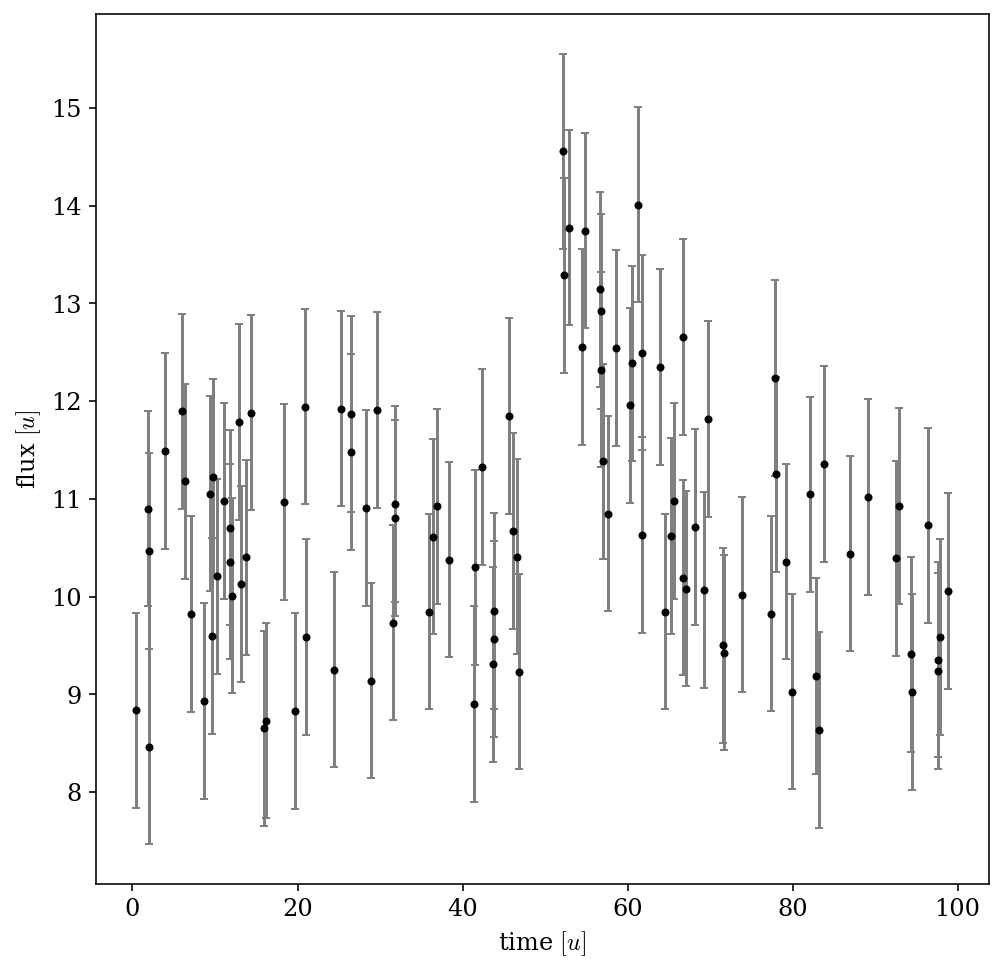

In [8]:
plt.errorbar(t, flux, yerr = sigma_flux, fmt ='.k', ecolor = 'gray', capsize = 2)
plt.xlabel(r'time $[u]$')
plt.ylabel(r'flux $[u]$')
plt.show()

### Burst model

In [9]:
#dynesty
ndim = 4
sampler = dynesty.NestedSampler(log_likelihood, prior, ndim, logl_args=[t, flux, sigma_flux, 'burst_model'], ptform_args=[limits, 'burst_model'], nlive = 100)
sampler.run_nested()
results = sampler.results

/var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_6892/3611236607.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
/var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_6892/3611236607.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
369it [00:17,  4.17it/s, bound: 0 | nc: 49 | ncall: 3695 | eff(%):  9.986 | loglstar:   -inf < -90.413 <    inf | logz: -98.078 +/-  0.362 | dlogz: 66.600 >  0.109]       /var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_6892/3611236607.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
/var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_6892/3611236607.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
436it [00:18, 58.35it/s, bound: 2 | nc: 1 | ncall: 3848

777it [00:29, 14.67it/s, bound: 12 | nc: 13 | ncall: 5443 | eff(%): 14.275 | loglstar:   -inf < -43.511 <    inf | logz: -49.528 +/-  0.329 | dlogz: 13.517 >  0.109]/var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_6892/3611236607.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
790it [00:30, 17.38it/s, bound: 12 | nc: 5 | ncall: 5563 | eff(%): 14.201 | loglstar:   -inf < -43.337 <    inf | logz: -49.504 +/-  0.329 | dlogz: 13.364 >  0.109] /var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_6892/3611236607.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
/var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_6892/3611236607.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
810it [00:31, 16.25it/s, bound: 13 | nc: 20 | ncall: 5748 | eff(%): 14.092 | loglstar: 

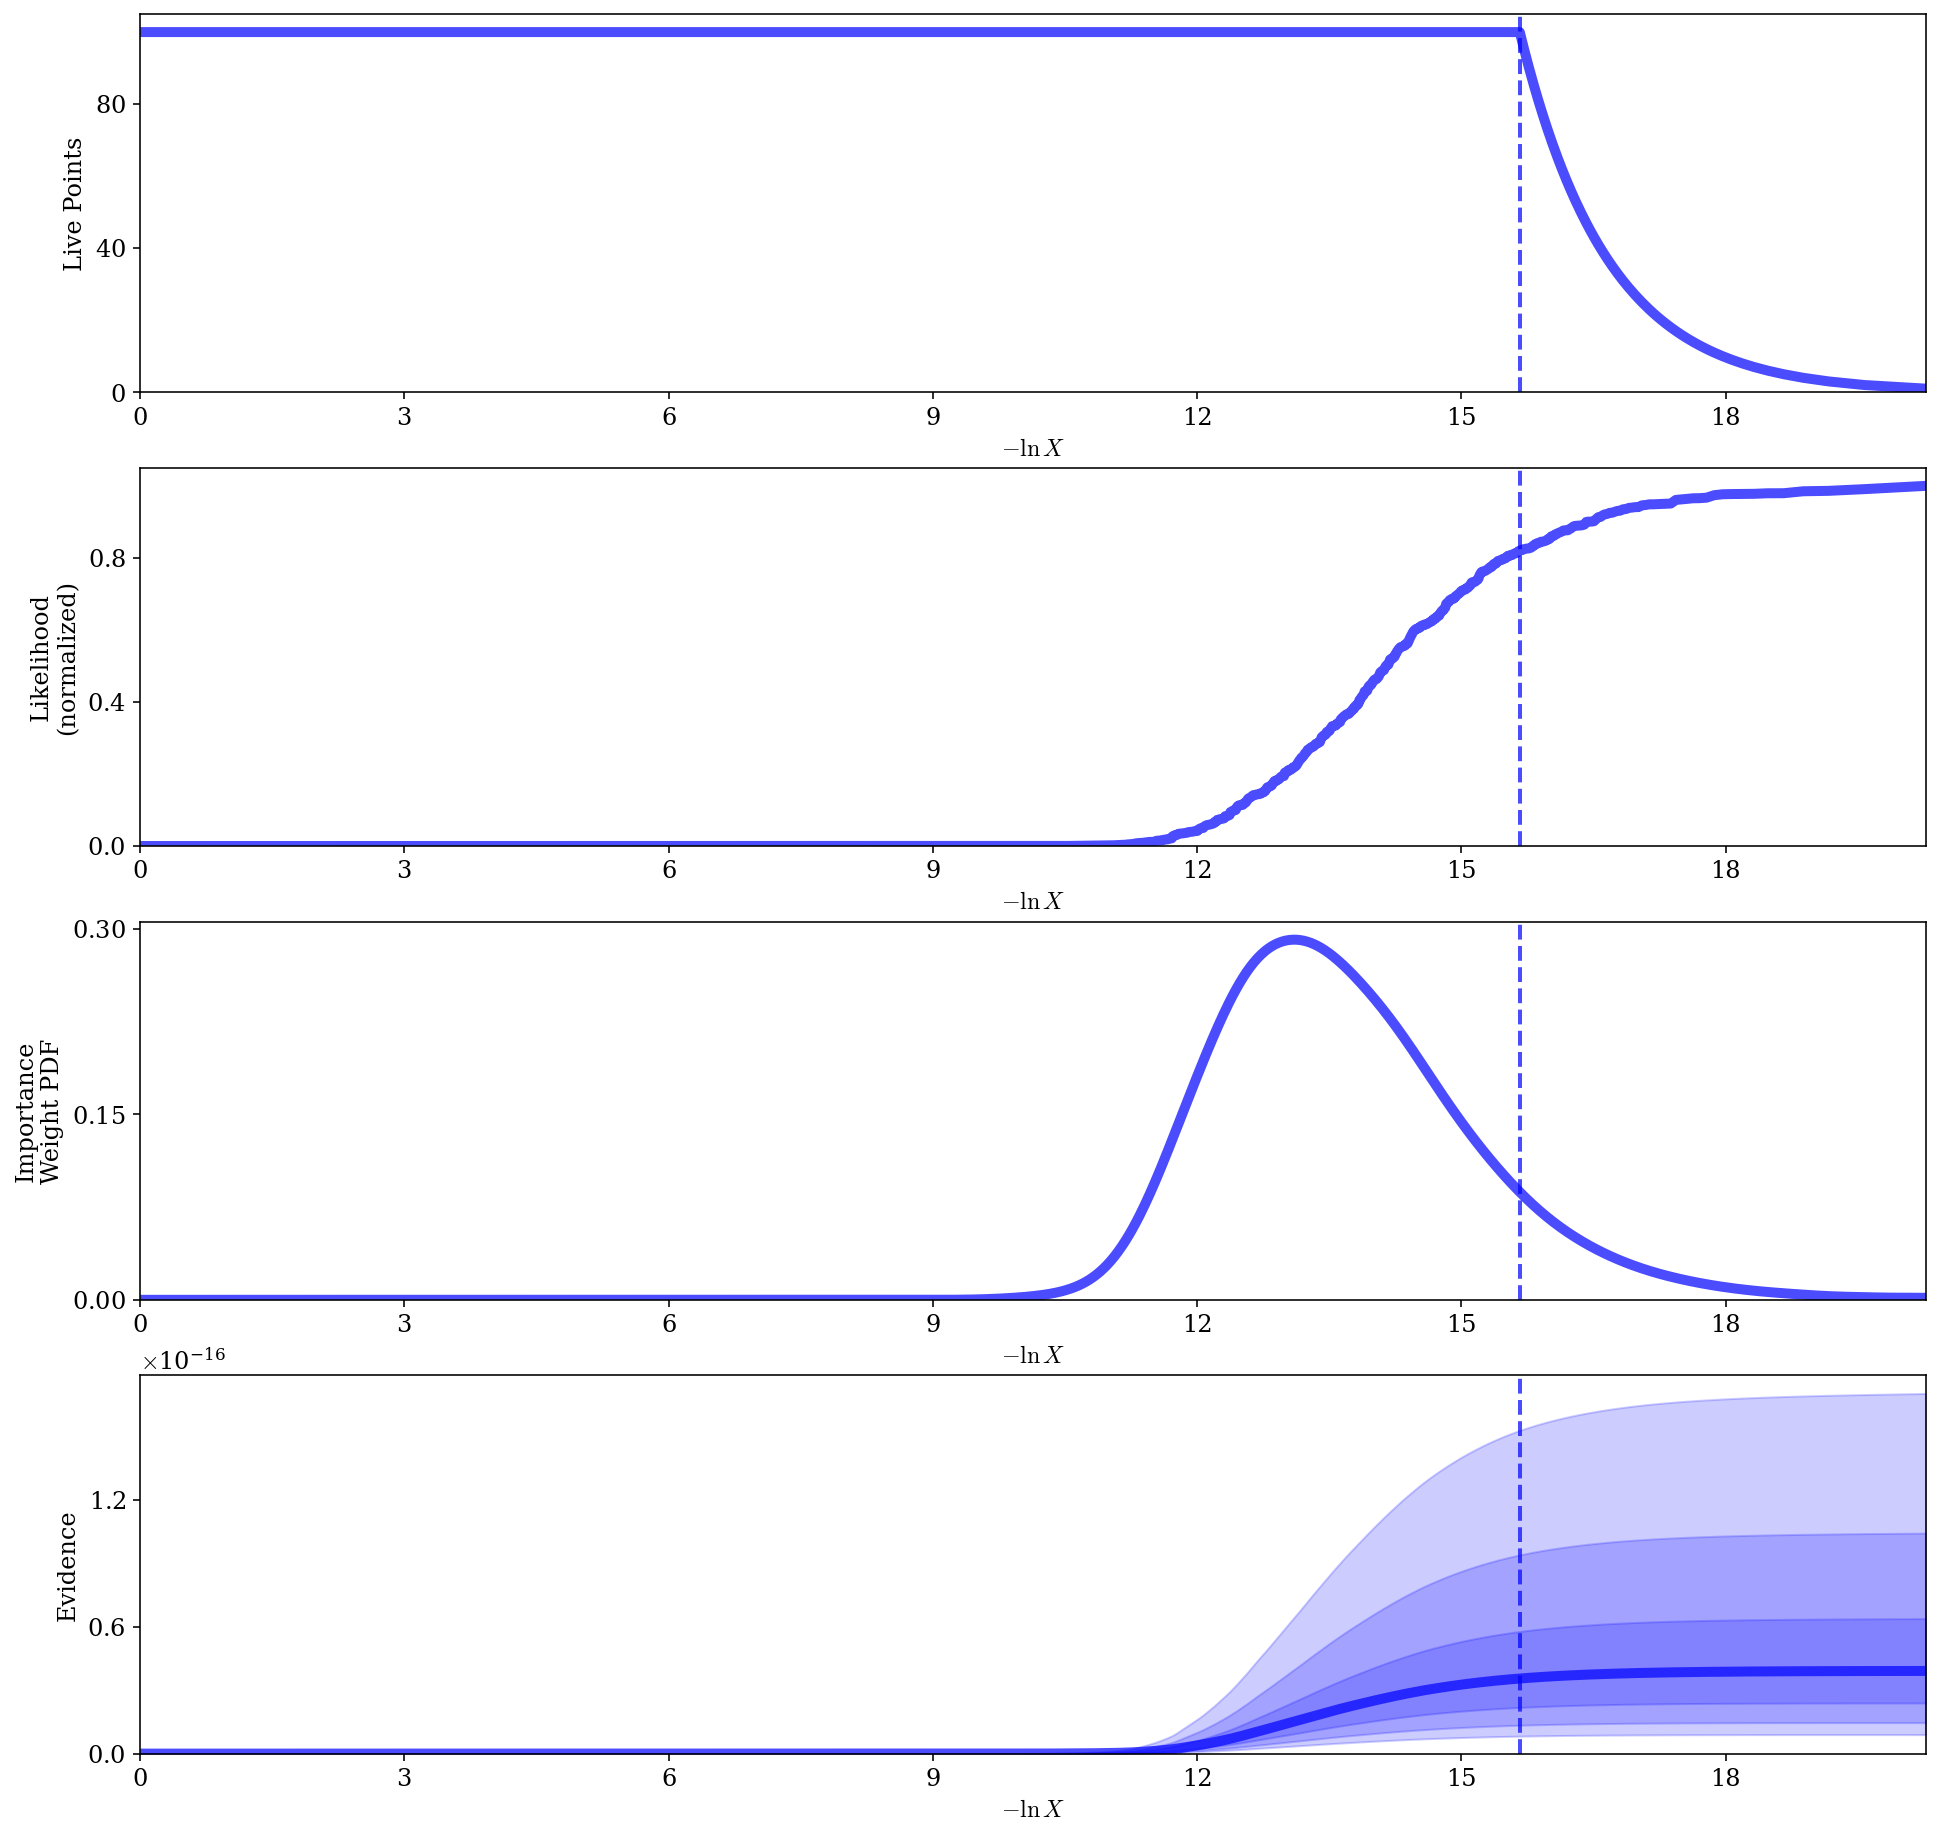

In [10]:
rfig, raxes = dyplot.runplot(results)

In [17]:
labels = ['b', 'A', r'$t_0$', r'$\alpha$']

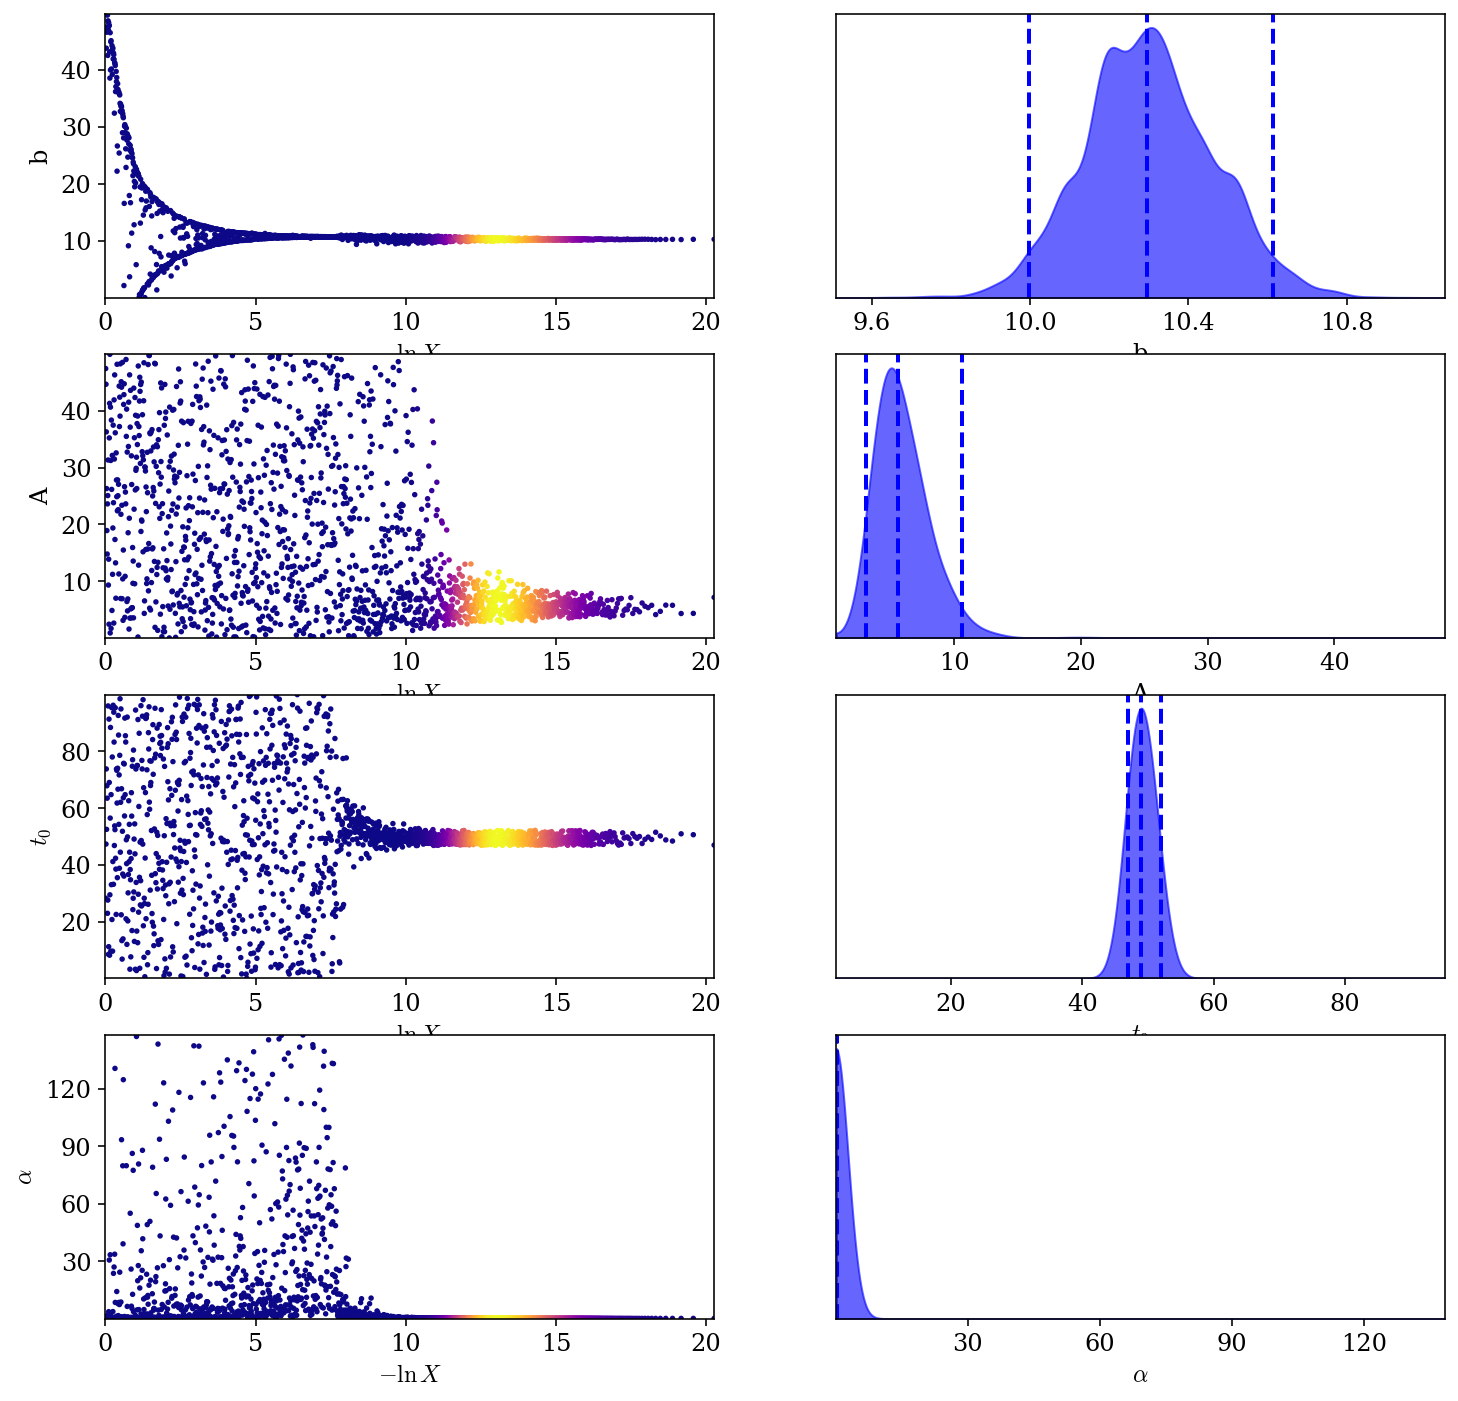

In [18]:
tfig, taxes = dyplot.traceplot(results, labels=labels)

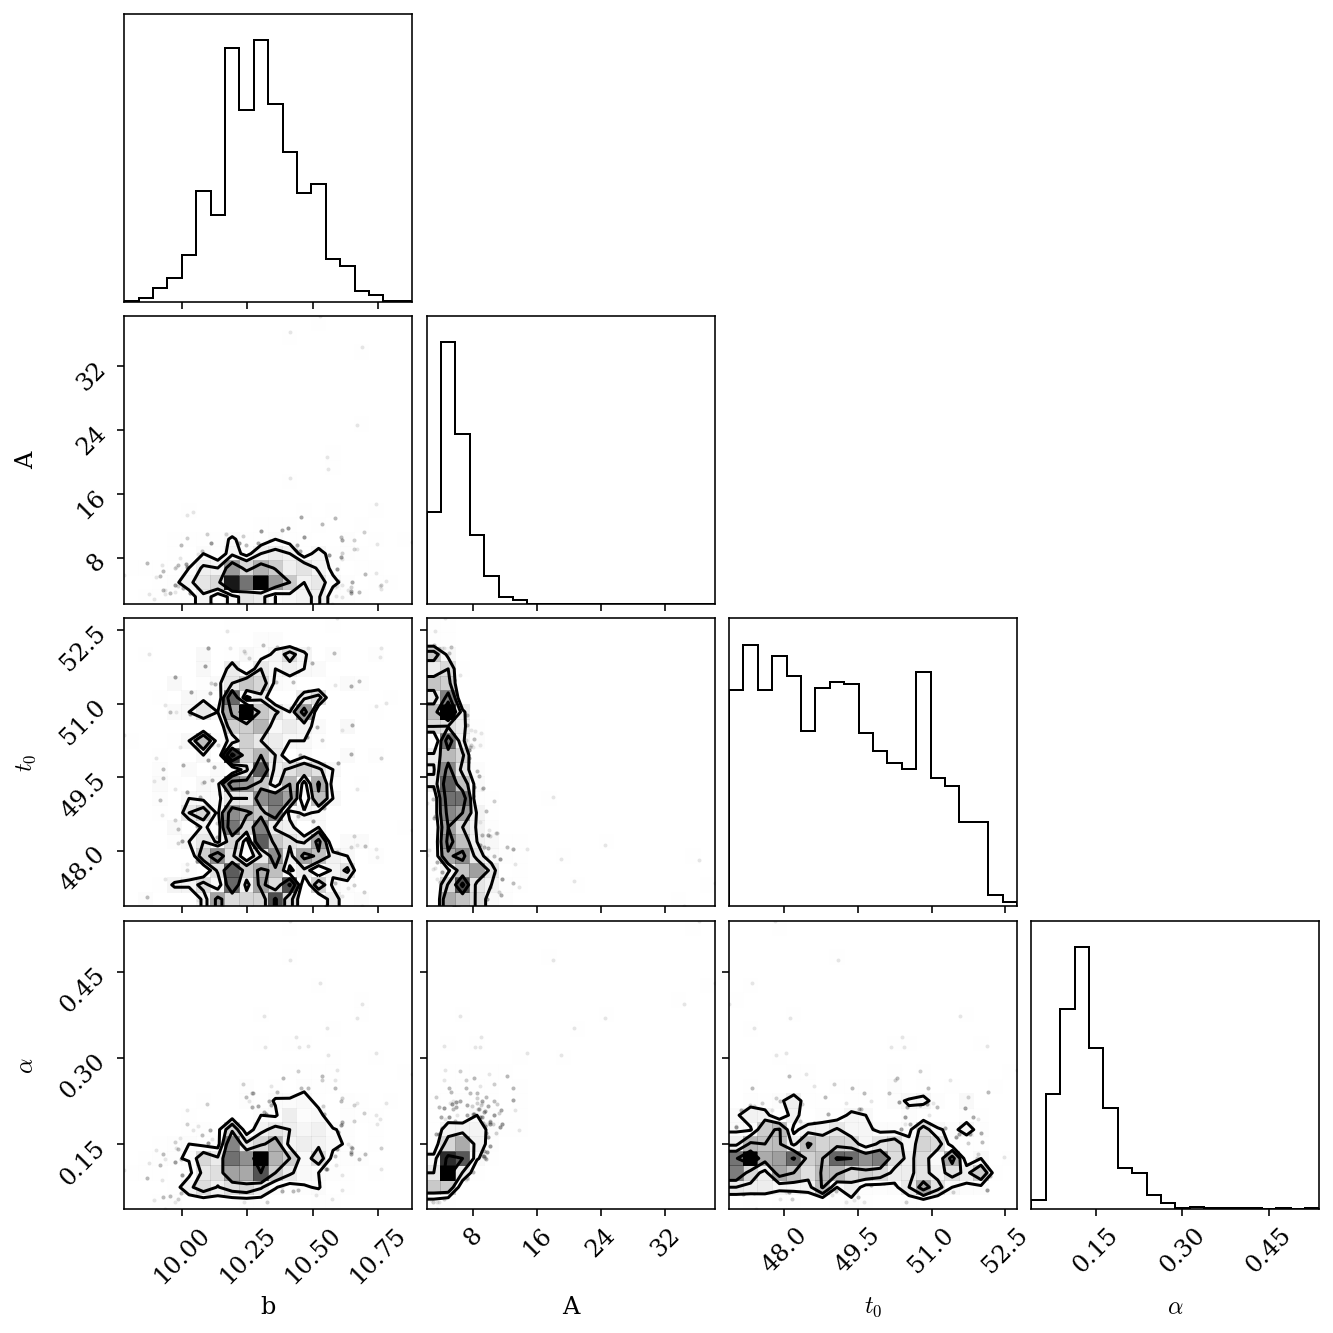

In [12]:
samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

samples_equal = dyfunc.resample_equal(samples, weights)

corner.corner(samples_equal, labels=labels);

In [13]:
#statistics
burst_evidence = results.logz[-1]
quantiles = [dyfunc.quantile(samps, [0.5, 0.05, 0.95], weights=weights)
             for samps in samples.T]
for i in range(ndim):    
    print(labels[i] + '= %.2f + %.2f - %.2f' % (quantiles[i][0], quantiles[i][0] - quantiles[i][1], quantiles[i][2] - quantiles[i][0]))

b= 10.30 + 0.26 - 0.27
A= 5.60 + 2.34 - 4.12
$t_0$= 48.97 + 1.88 - 2.65
$\alpha$= 0.13 + 0.05 - 0.09


In [14]:
results.summary()

Summary
nlive: 100
niter: 1573
ncall: 8685
eff(%): 19.263
logz: -37.781 +/-  0.491


### Gaussian profile

In [19]:
#dynesty
ndim = 4
sampler = dynesty.NestedSampler(log_likelihood, prior, ndim, logl_args=[t, flux, sigma_flux, 'gauss_model'], ptform_args=[limits, 'gauss_model'], nlive = 100)
sampler.run_nested()
results_g = sampler.results

1623it [00:48, 33.67it/s, +100 | bound: 34 | nc: 1 | ncall: 8985 | eff(%): 19.176 | loglstar:   -inf < -26.234 <    inf | logz: -40.136 +/-  0.490 | dlogz:  0.001 >  0.109]


In [20]:
labels_g = ['b', 'A', r'$t_0$', r'$\sigma_w$']

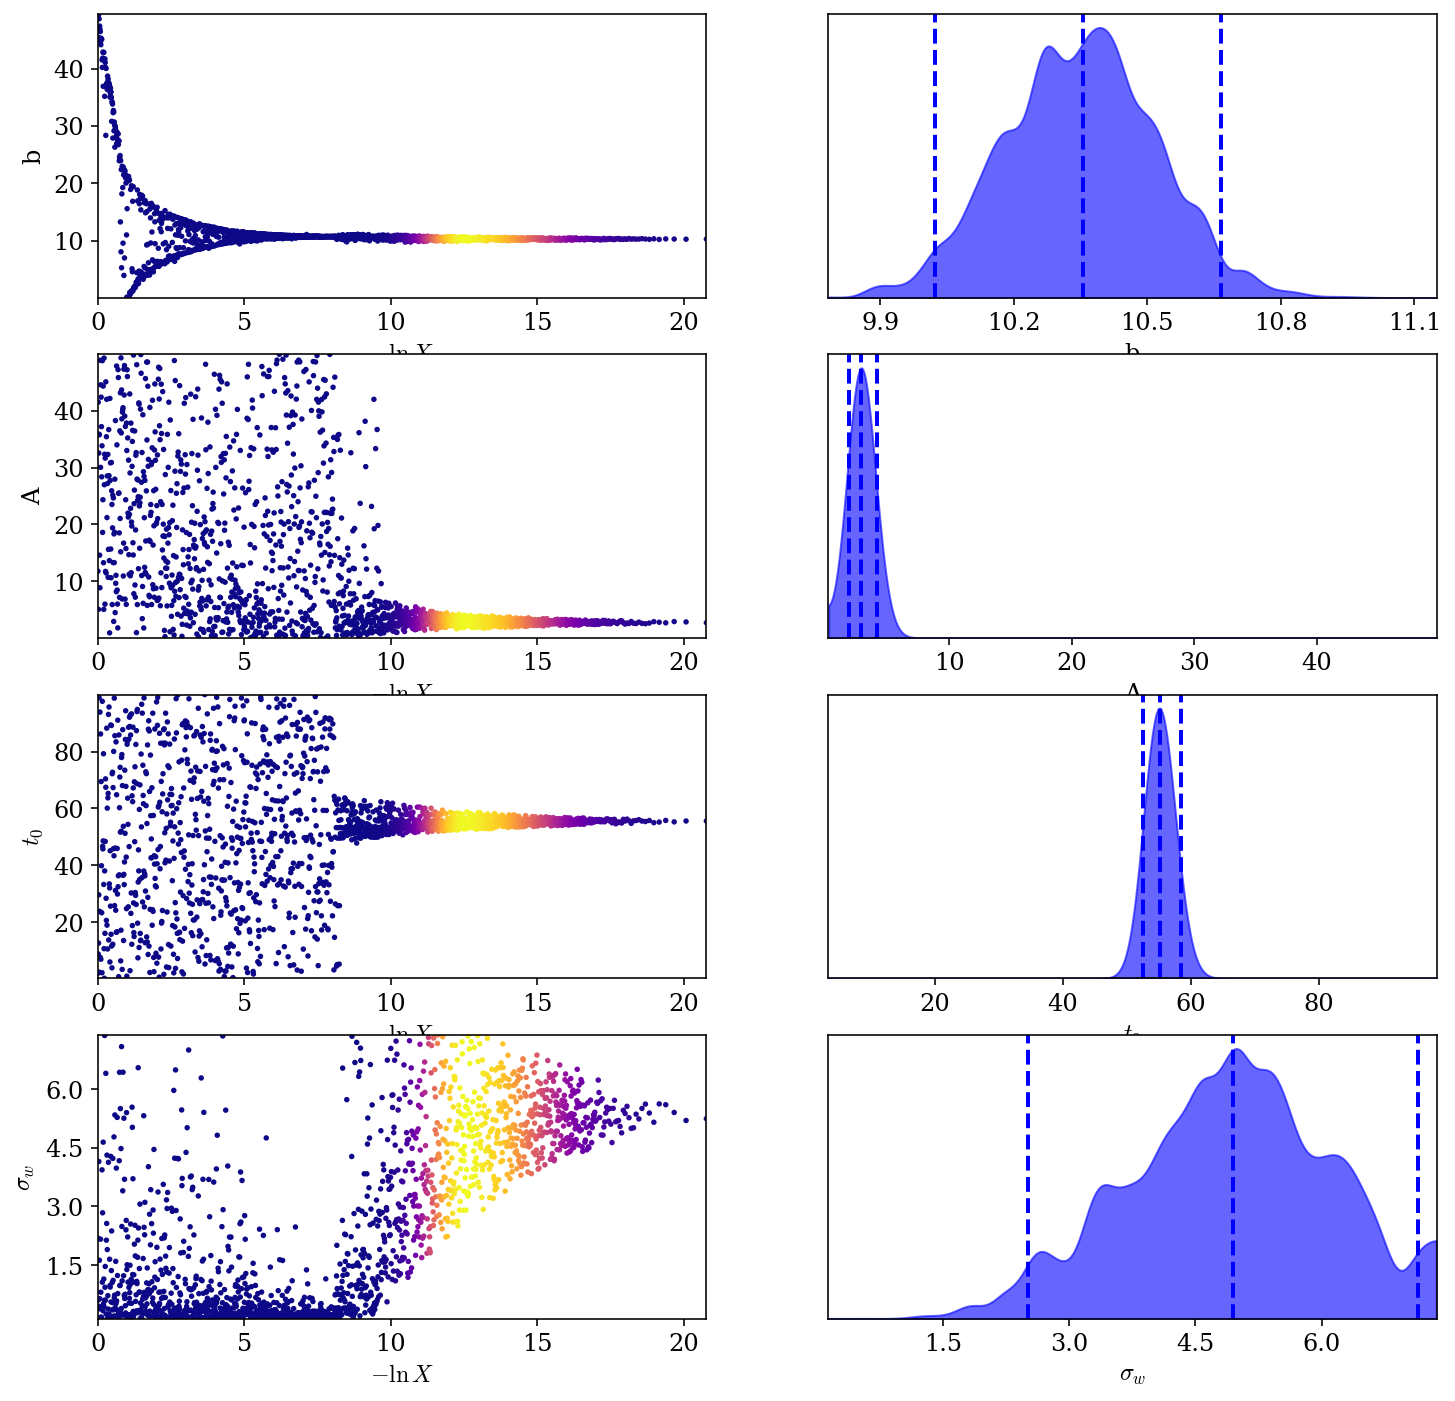

In [21]:
tfig, taxes = dyplot.traceplot(results_g, labels=labels_g)

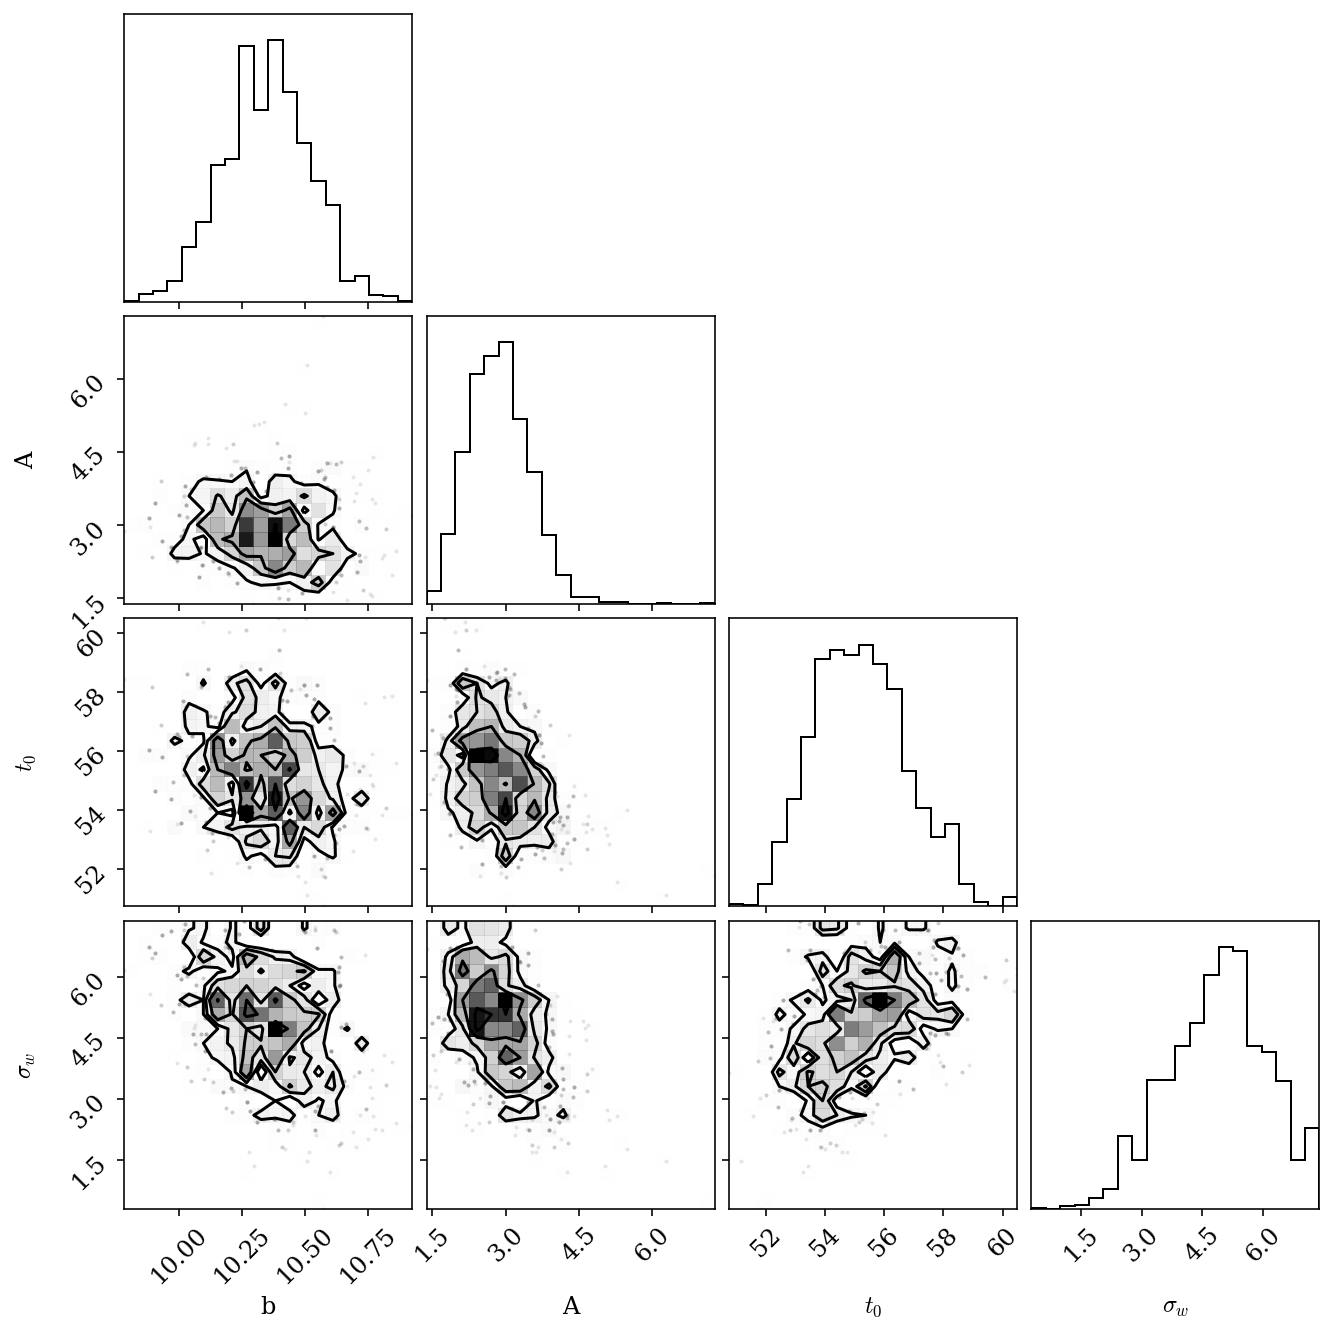

In [22]:
samples_g = results_g.samples  # samples
weights_g = np.exp(results_g.logwt - results_g.logz[-1])  # normalized weights

samples_g_equal = dyfunc.resample_equal(samples_g, weights_g)

corner.corner(samples_g_equal, labels=labels_g);

In [23]:
#statistics
gauss_evidence = results_g.logz[-1]
quantiles = [dyfunc.quantile(samps, [0.5, 0.05, 0.95], weights=weights_g)
             for samps in samples_g.T]
for i in range(ndim):    
    print(labels_g[i] + '= %.2f + %.2f - %.2f' % (quantiles[i][0], quantiles[i][0] - quantiles[i][1], quantiles[i][2] - quantiles[i][0]))

b= 10.36 + 0.29 - 0.27
A= 2.85 + 0.93 - 1.09
$t_0$= 55.14 + 2.28 - 2.92
$\sigma_w$= 4.95 + 2.20 - 1.79


In [24]:
results_g.summary()

Summary
nlive: 100
niter: 1623
ncall: 8985
eff(%): 19.176
logz: -40.136 +/-  0.490


### Bayesian evidence

In [25]:
evidence_ratio = burst_evidence - gauss_evidence
print(evidence_ratio / np.log(10), np.exp(evidence_ratio))

1.0229281086370705 10.542123718678793


evidence in favour of the burst model

In [26]:
# 100 random samples
N_rand = 20
mask = np.random.choice(len(samples_equal), size = N_rand)
choices = samples_equal[mask]
grid = np.linspace(min(t), max(t), 100)

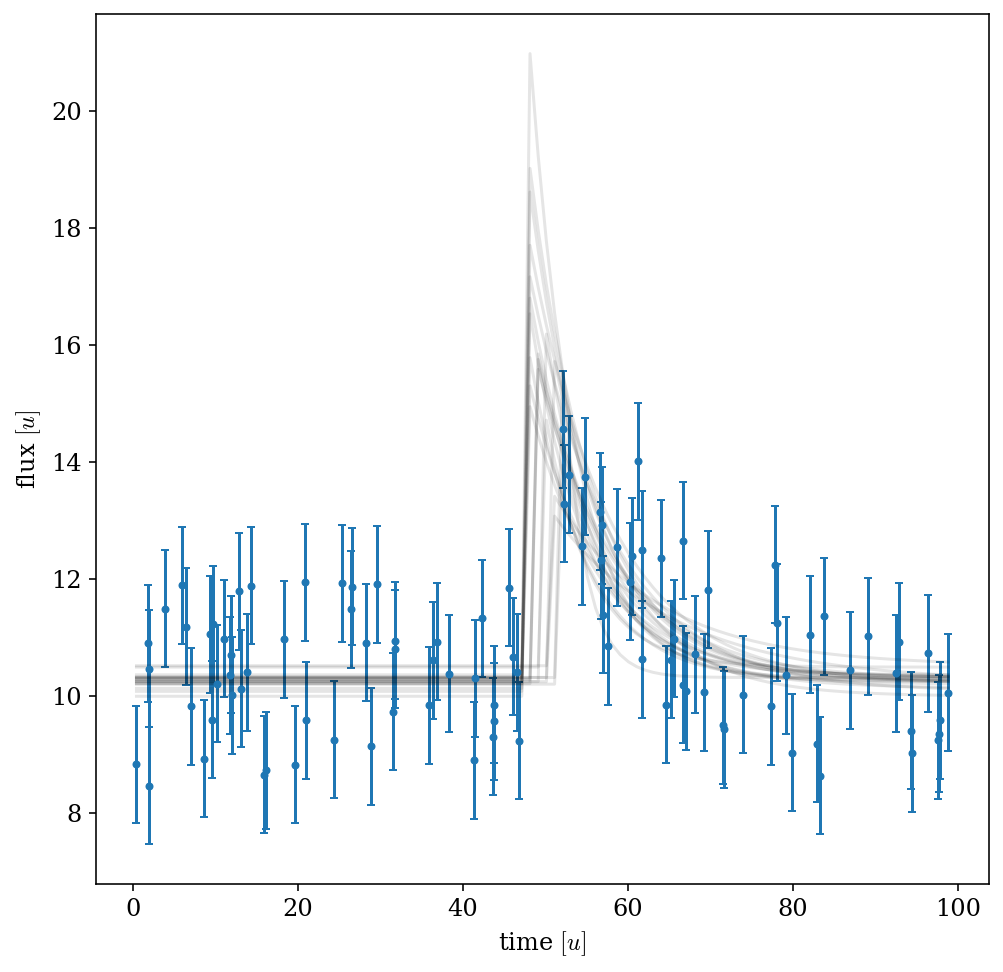

In [27]:
#plot
plt.figure()
plt.errorbar(t, flux, yerr = sigma_flux, fmt ='.', capsize = 2)

for choice in choices:
    plt.plot(grid, burst_model(choice, grid), c='k', alpha = .1)

plt.xlabel(r'time $[u]$')
plt.ylabel(r'flux $[u]$')
plt.show()